In [11]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import os
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
import re
import json

In [2]:
def is_valid_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

In [3]:
MAX_LEN = 128
BATCH_SIZE = 128
EMB_DIM = 256
LATENT_DIM = 128
N_HEADS = 8
FF_DIM = 512
NUM_LAYERS = 4
VOCAB_SPECIAL = ['<pad>', '<bos>', '<eos>', '<unk>']

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используем устройство: {DEVICE}")
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

Используем устройство: cuda
True
12.8
NVIDIA GeForce RTX 3060 Laptop GPU


In [61]:
# Загружаем датасет
df = pd.read_csv("data/polyOne_aa.csv")

# Проверяем наличие столбца SMILES (в вашем датасете он называется именно "smiles")
if "smiles" not in df.columns:
    raise ValueError("Столбец 'smiles' не найден в датасете. Проверьте название столбца.")

# Удаляем строки с пустыми SMILES
df = df.dropna(subset=["smiles"])

# Полный маппинг всех свойств из датасета с их расшифровкой
PROPERTY_MAPPING = {
    # Энергетические свойства
    "Egc": "Group Contribution Energy (kJ/mol)",
    "Egb": "Bond Energy Contribution (kJ/mol)",
    "Eib": "Internal Bond Energy (kJ/mol)",
    "CED": "Cohesive Energy Density (J/cm³)",
    "Ei": "Ionization Energy (eV)",
    "Eea": "Electron Affinity (eV)",
    "Eat": "Atomization Energy (kJ/mol)",
    
    # Структурные характеристики
    "nc": "Number of Carbon Atoms",
    "ne": "Number of Electrons",
    "Xc": "Crystallinity Index (%)",
    "Xe": "Crosslinking Density (mol/m³)",
    
    # Диэлектрические свойства (epse = epsilon, диэлектрическая проницаемость)
    "epse_6.0": "Dielectric Constant at 6.0 GHz",
    "epsc": "Static Dielectric Constant (0 Hz)",
    "epse_3.0": "Dielectric Constant at 3.0 GHz",
    "epse_1.78": "Dielectric Constant at 1.78 GHz",
    "epse_15.0": "Dielectric Constant at 15.0 GHz",
    "epse_4.0": "Dielectric Constant at 4.0 GHz",
    "epse_5.0": "Dielectric Constant at 5.0 GHz",
    "epse_2.0": "Dielectric Constant at 2.0 GHz",
    "epse_9.0": "Dielectric Constant at 9.0 GHz",
    "epse_7.0": "Dielectric Constant at 7.0 GHz",
    "epsb": "Breakdown Dielectric Strength (kV/mm)",
    
    # Механические свойства
    "TSb": "Tensile Strength at Break (MPa)",
    "TSy": "Tensile Strength at Yield (MPa)",
    "YM": "Young's Modulus (MPa)",
    
    # Газопроницаемость
    "permCH4": "Permeability to CH4 (Barrer)",
    "permCO2": "Permeability to CO2 (Barrer)",
    "permH2": "Permeability to H2 (Barrer)",
    "permO2": "Permeability to O2 (Barrer)",
    "permN2": "Permeability to N2 (Barrer)",
    "permHe": "Permeability to He (Barrer)",
    
    # Тепловые свойства
    "Cp": "Specific Heat Capacity (J/(g·K))",
    "Td": "Thermal Decomposition Temperature (K)",
    "Tg": "Glass Transition Temperature (K)",
    "Tm": "Melting Temperature (K)",
    
    # Другие физические свойства
    "rho": "Density (g/cm³)",
    "LOI": "Limiting Oxygen Index (%)"
}

# Все числовые признаки из датасета (в оригинальных названиях)
NUM_FEATURES = list(PROPERTY_MAPPING.keys())
print(f"Количество признаков: {len(NUM_FEATURES)}")
print(NUM_FEATURES[:5])

Количество признаков: 37
['Egc', 'Egb', 'Eib', 'CED', 'Ei']


In [7]:
def fix_polymer_smiles(smiles):
    """
    Корректное исправление полимерных SMILES для RDKit
    Заменяет [*] на [*:1] и [*:2] и исправляет синтаксические ошибки
    """
    # Шаг 1: Замена [*] на нумерованные точки присоединения
    # Считаем количество [*] для правильной нумерации
    star_count = smiles.count('[*]')
    
    if star_count == 1:
        fixed_smiles = smiles.replace('[*]', '[*:1]')
    elif star_count >= 2:
        # Заменяем первое вхождение на [*:1], второе на [*:2]
        fixed_smiles = re.sub(r'\[\*\]', '[*:1]', smiles, count=1)
        fixed_smiles = re.sub(r'\[\*\]', '[*:2]', fixed_smiles, count=1)
        # Удаляем оставшиеся [*] (если есть)
        fixed_smiles = re.sub(r'\[\*\]', '', fixed_smiles)
    else:
        fixed_smiles = smiles  # Нет звёздочек
    
    # Шаг 2: Исправление критических синтаксических ошибок
    # Пример: "n2on2" → "n2cnc2" (для 1,2,3-триазола)
    fixed_smiles = re.sub(r'n(\d+)on\1', r'n\1cnc\1', fixed_smiles, flags=re.IGNORECASE)
    
    # Шаг 3: Балансировка скобок (частая проблема в полимерных SMILES)
    open_paren = fixed_smiles.count('(')
    close_paren = fixed_smiles.count(')')
    if open_paren > close_paren:
        fixed_smiles += ')' * (open_paren - close_paren)
    elif close_paren > open_paren:
        fixed_smiles = fixed_smiles.rstrip(')') + ')' * (close_paren - (close_paren - open_paren))
    
    # Шаг 4: Проверка валидности с отключенной санитизацией
    try:
        mol = Chem.MolFromSmiles(fixed_smiles, sanitize=False)
        if mol is not None and mol.GetNumAtoms() > 3:
            # Попытка частичной санитизации
            try:
                Chem.SanitizeMol(
                    mol,
                    sanitizeOps=Chem.SanitizeFlags.SANITIZE_FINDRADICALS |
                                Chem.SanitizeFlags.SANITIZE_KEKULIZE |
                                Chem.SanitizeFlags.SANITIZE_SETAROMATICITY,
                    catchErrors=True
                )
            except:
                pass
            return Chem.MolToSmiles(mol, canonical=True, allBondsExplicit=False)
    except Exception as e:
        pass
    
    # Если не сработало - пробуем альтернативное исправление
    return aggressive_fix(fixed_smiles)

def aggressive_fix(smiles):
    """Агрессивное исправление для критических случаев"""
    # Удаляем все кольцевые связи (временно для валидации)
    no_rings = re.sub(r'\d', '', smiles)
    if Chem.MolFromSmiles(no_rings, sanitize=False) is not None:
        return no_rings
    
    # Заменяем проблемные фрагменты
    replacements = [
        (r'N\(\[\*:2\]\)', 'N[*:2]'),  # Исправление скобок вокруг точек присоединения
        (r'OCCn', 'OCCN'),             # Исправление регистра азота
        (r'-c', '-C'),                 # Ароматические связи в начале
    ]
    for pattern, repl in replacements:
        smiles = re.sub(pattern, repl, smiles)
    
    return smiles

In [8]:
def process_polymer_dataset(df):
    """Полная обработка полимерного датасета с логированием"""
    results = {
        'clean_smiles': [],
        'fix_status': [],
        'atom_count': [],
        'attachment_points': []
    }
    
    stats = {
        'original_valid': 0,
        'fixed_success': 0,
        'partially_fixed': 0,
        'unfixable': 0
    }
    
    for smiles in df['smiles']:
        # Проверяем исходную валидность
        orig_mol = Chem.MolFromSmiles(smiles, sanitize=False)
        if orig_mol is not None and orig_mol.GetNumAtoms() > 3:
            results['clean_smiles'].append(smiles)
            results['fix_status'].append('original_valid')
            results['atom_count'].append(orig_mol.GetNumAtoms())
            results['attachment_points'].append(
                sum(1 for a in orig_mol.GetAtoms() if a.GetAtomicNum() == 0)
            )
            stats['original_valid'] += 1
            continue
        
        # Пробуем исправить
        fixed = fix_polymer_smiles(smiles)
        mol = Chem.MolFromSmiles(fixed, sanitize=False)
        
        if mol is not None and mol.GetNumAtoms() > 3:
            # Проверяем наличие точек присоединения
            attachment_points = [a for a in mol.GetAtoms() if a.GetAtomicNum() == 0]
            
            if len(attachment_points) >= 1:
                results['clean_smiles'].append(fixed)
                results['fix_status'].append('fixed_success')
                stats['fixed_success'] += 1
            else:
                results['clean_smiles'].append(fixed)
                results['fix_status'].append('partially_fixed')
                stats['partially_fixed'] += 1
            
            results['atom_count'].append(mol.GetNumAtoms())
            results['attachment_points'].append(len(attachment_points))
        else:
            results['clean_smiles'].append(None)
            results['fix_status'].append('unfixable')
            results['atom_count'].append(0)
            results['attachment_points'].append(0)
            stats['unfixable'] += 1
    
    # Добавляем результаты в DataFrame
    for col, data in results.items():
        df[col] = data
    
    # Вывод статистики
    total = len(df)
    print("Статистика обработки полимерных SMILES:")
    for status, count in stats.items():
        print(f"- {status}: {count} ({count/total:.1%})")
    
    # Фильтруем только успешные исправления
    valid_df = df[df['fix_status'].isin(['original_valid', 'fixed_success'])].copy()
    print(f"\nГотово к использованию в обучении: {len(valid_df)}/{total} ({len(valid_df)/total:.1%})")
    
    return valid_df, stats

# Применение к вашему датасету
valid_df, stats = process_polymer_dataset(df)

KeyboardInterrupt: 

In [26]:
valid_df[0:10]

In [45]:
# Тест на вашем критическом примере
invalid_smiles = "[*]c1ccc(-c2ccc(S(=O)(=O)c3ccc(C(=O)c4ccc(C(F)(F)F)c(-c5ccc([*])cc5)c4)cc3)cc2)cc1"
mol = is_valid_smiles(invalid_smiles)
print(mol)

fixed = fix_polymer_smiles(invalid_smiles)

# Финальная проверка валидности
mol = is_valid_smiles(fixed)
print(mol)

In [60]:
# Нормализация признаков
print(df[NUM_FEATURES].iloc[:5].values)

scaler = MinMaxScaler()
df[NUM_FEATURES] = scaler.fit_transform(df[NUM_FEATURES])

print(df[NUM_FEATURES].iloc[:5].values)


[[ 3.85035010e+00  3.50069070e+00  3.77107520e+00  1.30611400e+02
   5.82937670e+00  2.22957300e+00 -5.53235150e+00  2.17018100e+00
   1.73311700e+00  7.55586900e+01  6.95618400e+01  4.31129550e+00
   5.47767450e+00  4.79228400e+00  5.18214200e+00  3.02680500e+00
   4.59417800e+00  4.44908240e+00  5.09462260e+00  3.82713720e+00
   4.14322700e+00  8.28091800e+00  6.70790200e+01  5.64482040e+01
   2.15180220e+03  4.54934720e-01  5.17654750e+00  1.67302000e+01
   1.48769330e+00  4.34531800e-01  1.81093710e+01  1.67955360e+00
   6.78080900e+02  4.98776030e+02  5.83849000e+02  1.61465410e+00
   5.79798620e+01]
 [ 3.48893050e+00  3.10614870e+00  3.54478650e+00  1.32975950e+02
   5.68841900e+00  2.22155120e+00 -6.04946850e+00  2.05616700e+00
   1.68515410e+00  4.04310400e+01  3.72884800e+01  3.74494890e+00
   4.84396120e+00  4.04057740e+00  4.35096700e+00  2.83872060e+00
   3.92446660e+00  3.83376200e+00  4.27440170e+00  3.42396830e+00
   3.64281870e+00  1.06506230e+01  7.66963900e+01  6.1292

In [14]:
def tokenize(smiles):
    return list(smiles)

all_tokens = set()
for s in df["smiles"]:
    all_tokens.update(tokenize(s))

tokens = VOCAB_SPECIAL + sorted(list(all_tokens))
token2idx = {t: i for i, t in enumerate(tokens)}
idx2token = {i: t for t, i in token2idx.items()}
vocab_size = len(token2idx)

In [15]:
class ConditionalSMILESDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe["smiles"].tolist()
        self.features = dataframe[NUM_FEATURES].values.astype(np.float32)

    def __len__(self):
        return len(self.data)

    def encode_smiles(self, smiles):
        tokens_seq = ['<bos>'] + list(smiles) + ['<eos>']
        token_ids = [token2idx.get(t, token2idx['<unk>']) for t in tokens_seq]
        token_ids = token_ids[:MAX_LEN]
        if len(token_ids) < MAX_LEN:
            token_ids += [token2idx['<pad>']] * (MAX_LEN - len(token_ids))
        return torch.tensor(token_ids)

    def __getitem__(self, idx):
        x = self.encode_smiles(self.data[idx])
        tgt_input = x[:-1]
        tgt_output = x[1:]
        feats = torch.tensor(self.features[idx])
        return tgt_input, tgt_output, feats

In [16]:
class ConditionalTransformerVAE(nn.Module):
    def __init__(self, vocab_size, emb_dim, latent_dim, num_heads, ff_dim, num_layers, max_len, feature_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=token2idx['<pad>'])
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, emb_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.feat_encoder = nn.Linear(feature_dim, latent_dim)
        self.fc_mu = nn.Linear(emb_dim + latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(emb_dim + latent_dim, latent_dim)
        self.decoder_proj = nn.Linear(latent_dim + latent_dim, emb_dim)

        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.out = nn.Linear(emb_dim, vocab_size)

    def encode(self, src, feats):
        src_mask = (src == token2idx['<pad>']).bool()
        src_emb = self.emb(src) + self.pos_emb[:, :src.size(1)]
        src_enc = self.encoder(src_emb.transpose(0,1), src_key_padding_mask=src_mask)
        cls_token = src_enc[0, :, :]
        feats_emb = self.feat_encoder(feats)
        combined = torch.cat([cls_token, feats_emb], dim=1)
        mu = self.fc_mu(combined)
        logvar = self.fc_logvar(combined)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)  # фиксируем logvar
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, feats, tgt_inp):
        tgt_mask = (tgt_inp == token2idx['<pad>']).bool()
        z_dec = torch.cat([z, self.feat_encoder(feats)], dim=1).unsqueeze(1).repeat(1, tgt_inp.size(1), 1)
        tgt_emb = self.emb(tgt_inp) + self.pos_emb[:, :tgt_inp.size(1)]
        tgt_seq_mask = nn.Transformer.generate_square_subsequent_mask(tgt_inp.size(1)).to(z.device)
        out = self.decoder(tgt=tgt_emb.transpose(0,1), memory=z_dec.transpose(0,1), tgt_mask=tgt_seq_mask, tgt_key_padding_mask=tgt_mask)
        logits = self.out(out.transpose(0,1))
        return logits

    def forward(self, src, feats, tgt_inp):
        mu, logvar = self.encode(src, feats)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z, feats, tgt_inp)
        return logits, mu, logvar

In [17]:
def conditional_vae_loss(logits, targets, mu, logvar, pad_idx=token2idx['<pad>']):
    recon_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=pad_idx)
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recon_loss + kl_loss, recon_loss, kl_loss


In [18]:
def generate_smiles_conditional(model, target_feats, num_samples=10, temperature=1.0):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, LATENT_DIM).to(DEVICE)
        target_feats = target_feats.to(DEVICE)
        z_dec = torch.cat([z, model.feat_encoder(target_feats)], dim=1).unsqueeze(1)
        input_token = torch.tensor([token2idx['<bos>']] * num_samples).unsqueeze(1).to(DEVICE)
        sequences = input_token
        finished = torch.zeros(num_samples, dtype=torch.bool).to(DEVICE)

        for _ in range(MAX_LEN - 1):
            emb = model.emb(sequences) + model.pos_emb[:, :sequences.size(1)]
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequences.size(1)).to(DEVICE)
            out = model.decoder(emb.transpose(0,1), z_dec.transpose(0,1), tgt_mask=tgt_mask)
            logits = model.out(out.transpose(0,1))[:, -1] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).squeeze(1)
            finished = finished | (next_token == token2idx['<eos>'])
            if finished.all(): break
            sequences = torch.cat([sequences, next_token.unsqueeze(1)], dim=1)

        smiles_list = []
        for seq in sequences:
            tokens_seq = [idx2token[i.item()] for i in seq]
            if '<eos>' in tokens_seq:
                tokens_seq = tokens_seq[:tokens_seq.index('<eos>')]
            smiles = ''.join([t for t in tokens_seq if t not in VOCAB_SPECIAL])
            smiles_list.append(smiles)
        return smiles_list

In [19]:
subset_df = df.head(500_000)
dataset = ConditionalSMILESDataset(subset_df)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

model = ConditionalTransformerVAE(
    vocab_size=len(token2idx),
    emb_dim=EMB_DIM,
    latent_dim=LATENT_DIM,
    num_heads=N_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    max_len=MAX_LEN,
    feature_dim=len(NUM_FEATURES)
).to(DEVICE)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


C:\drivers\python_inter\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [56]:
checkpoint_dir = 'checkpoints_VAE'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_conditional.pth')

start_epoch = 0
best_loss = float('inf')
loss_history = []

EPOCHS = 20

for epoch in range(start_epoch, start_epoch + EPOCHS):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for tgt_inp, tgt_out, feats in tqdm(loader, desc=f"Epoch {epoch+1}"):
        tgt_inp, tgt_out, feats = tgt_inp.to(DEVICE), tgt_out.to(DEVICE), feats.to(DEVICE)
        optimizer.zero_grad()
        logits, mu, logvar = model(tgt_inp, feats, tgt_inp)
        loss, recon_loss, kl_loss = conditional_vae_loss(logits, tgt_out, mu, logvar)
        
        if torch.isnan(loss):
            print("NaN detected! Skipping step")
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # градиентный клиппинг
        optimizer.step()
        
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    avg_loss = total_loss / len(loader)
    avg_recon = total_recon / len(loader)
    avg_kl = total_kl / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}")

Epoch 1:   0%|          | 0/3907 [00:00<?, ?it/s]C:\drivers\python_inter\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Epoch 1: 100%|██████████| 3907/3907 [16:25<00:00,  3.96it/s]


Epoch 1 | Loss: 0.7330 | Recon: 0.7135 | KL: 0.0195


Epoch 2: 100%|██████████| 3907/3907 [16:57<00:00,  3.84it/s]


Epoch 2 | Loss: 0.4592 | Recon: 0.4583 | KL: 0.0009


Epoch 3: 100%|██████████| 3907/3907 [16:39<00:00,  3.91it/s]


Epoch 3 | Loss: 0.3870 | Recon: 0.3868 | KL: 0.0002


Epoch 4: 100%|██████████| 3907/3907 [17:20<00:00,  3.76it/s]


Epoch 4 | Loss: 0.3474 | Recon: 0.3473 | KL: 0.0001


Epoch 5: 100%|██████████| 3907/3907 [17:19<00:00,  3.76it/s]


Epoch 5 | Loss: 0.3209 | Recon: 0.3209 | KL: 0.0001


Epoch 6: 100%|██████████| 3907/3907 [17:20<00:00,  3.76it/s]


Epoch 6 | Loss: 0.3021 | Recon: 0.3021 | KL: 0.0001


Epoch 7: 100%|██████████| 3907/3907 [17:19<00:00,  3.76it/s]


Epoch 7 | Loss: 0.2876 | Recon: 0.2876 | KL: 0.0001


Epoch 8: 100%|██████████| 3907/3907 [17:20<00:00,  3.76it/s]


Epoch 8 | Loss: 0.2761 | Recon: 0.2761 | KL: 0.0001


Epoch 9: 100%|██████████| 3907/3907 [17:20<00:00,  3.75it/s]


Epoch 9 | Loss: 0.2663 | Recon: 0.2662 | KL: 0.0000


Epoch 10: 100%|██████████| 3907/3907 [17:19<00:00,  3.76it/s]


Epoch 10 | Loss: 0.2579 | Recon: 0.2578 | KL: 0.0000


Epoch 11: 100%|██████████| 3907/3907 [17:20<00:00,  3.75it/s]


Epoch 11 | Loss: 0.2505 | Recon: 0.2504 | KL: 0.0000


Epoch 12: 100%|██████████| 3907/3907 [17:20<00:00,  3.75it/s]


Epoch 12 | Loss: 0.2440 | Recon: 0.2439 | KL: 0.0000


Epoch 13: 100%|██████████| 3907/3907 [17:21<00:00,  3.75it/s]


Epoch 13 | Loss: 0.2382 | Recon: 0.2382 | KL: 0.0000


Epoch 14: 100%|██████████| 3907/3907 [17:21<00:00,  3.75it/s]


Epoch 14 | Loss: 0.2331 | Recon: 0.2330 | KL: 0.0000


Epoch 15: 100%|██████████| 3907/3907 [17:20<00:00,  3.75it/s]


Epoch 15 | Loss: 0.2285 | Recon: 0.2285 | KL: 0.0000


Epoch 16: 100%|██████████| 3907/3907 [17:22<00:00,  3.75it/s]


Epoch 16 | Loss: 0.2244 | Recon: 0.2244 | KL: 0.0000


Epoch 17: 100%|██████████| 3907/3907 [17:21<00:00,  3.75it/s]


Epoch 17 | Loss: 0.2207 | Recon: 0.2206 | KL: 0.0000


Epoch 18: 100%|██████████| 3907/3907 [17:21<00:00,  3.75it/s]


Epoch 18 | Loss: 0.2172 | Recon: 0.2172 | KL: 0.0000


Epoch 19: 100%|██████████| 3907/3907 [17:22<00:00,  3.75it/s]


Epoch 19 | Loss: 0.2140 | Recon: 0.2140 | KL: 0.0000


Epoch 20: 100%|██████████| 3907/3907 [16:54<00:00,  3.85it/s]

Epoch 20 | Loss: 0.2111 | Recon: 0.2111 | KL: 0.0000


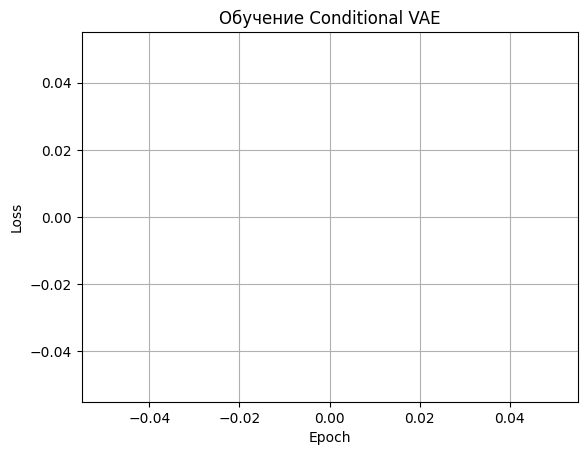

In [28]:
plt.plot(loss_history)
plt.title("Обучение Conditional VAE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [20]:
def load_pretrained_model(model, checkpoint_path=None):
    """
    Загружает предобученную модель из указанного пути или последнего чекпоинта
    Возвращает: (модель, оптимизатор, start_epoch, best_loss, loss_history)
    """
    start_epoch = 0
    best_loss = float('inf')
    loss_history = []
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    
    # Путь к конкретной модели, которую вы указали
    specific_model_path = "models/generation_model/new data/generate_500k_20of20.pth"
    
    # Определяем, какой файл загружать
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        load_path = checkpoint_path
        print(f"🔍 Загрузка последнего чекпоинта: {load_path}")
    elif os.path.exists(specific_model_path):
        load_path = specific_model_path
        print(f"🔍 Загрузка специфической модели: {load_path}")
    else:
        print("🆕 Модель не найдена. Создается новая модель.")
        return model, optimizer, start_epoch, best_loss, loss_history
    
    try:
        # Загружаем чекпоинт
        checkpoint = torch.load(load_path, map_location=DEVICE)
        
        # Обрабатываем разные форматы сохранения
        if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
            # Формат чекпоинта с метаданными
            model.load_state_dict(checkpoint['model_state_dict'])
            
            if 'optimizer_state_dict' in checkpoint:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            start_epoch = checkpoint.get('epoch', 0) + 1
            best_loss = checkpoint.get('best_loss', float('inf'))
            loss_history = checkpoint.get('loss_history', [])
            
            print(f"✅ Чекпоинт загружен успешно! Продолжаем с эпохи {start_epoch}")
            print(f"📊 Лучший loss: {best_loss:.4f}")
            print(f"📈 Количество сохраненных эпох в истории: {len(loss_history)}")
        
        else:
            # Просто state_dict модели
            model.load_state_dict(checkpoint)
            print("✅ Веса модели загружены успешно! Начинаем обучение с нуля.")
        
        # Перемещаем модель на правильное устройство
        model = model.to(DEVICE)
        
    except Exception as e:
        print(f"❌ Ошибка при загрузке модели: {str(e)}")
        print("🔄 Создается новая модель для обучения с нуля.")
    
    return model, optimizer, start_epoch, best_loss, loss_history

In [21]:
# Загружаем модель либо из конкретного пути, либо из последнего чекпоинта

# Если вы хотите использовать конкретную версию для генерации без обучения:
USE_MODEL_FOR_GENERATION_ONLY = True
#checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_conditional.pth')
model, optimizer, start_epoch, best_loss, loss_history = load_pretrained_model(
    model, 
    checkpoint_path=None  # Установите в None для загрузки вашей специфической модели
)

🔍 Загрузка специфической модели: models/generation_model/new data/generate_500k_20of20.pth
✅ Веса модели загружены успешно! Начинаем обучение с нуля.


In [85]:
from sklearn.metrics import euclidean_distances


def prepare_features_by_similarity(json_path, original_df, scaler, num_features, 
                                  num_samples=5, device='cuda'):
    """
    Подготавливает тензор признаков, находя наиболее похожие примеры в датафрейме
    
    Эта функция ищет в оригинальном датафрейме примеры, которые наиболее близки
    к целевым свойствам из JSON файла, что обеспечивает более естественное распределение признаков
    
    Args:
        json_path (str): путь к JSON файлу с параметрами от NLP модуля
        original_df (pd.DataFrame): исходный НЕНОРМАЛИЗОВАННЫЙ датафрейм
        scaler (sklearn.preprocessing.MinMaxScaler): обученный scaler
        num_features (list): список всех признаков для генерации
        num_samples (int): количество похожих примеров для выбора
        device (str): устройство для тензора ('cpu' или 'cuda')
        
    Returns:
        torch.Tensor: нормализованный тензор признаков [num_samples, n_features]
    """
    
    print("=== Поиск похожих примеров в датафрейме ===")
    
    # 1. Загрузка JSON файла
    try:
        with open(json_path, 'r', encoding='utf-8') as f:
            json_params = json.load(f)
        print(f"✅ JSON файл успешно загружен: {json_path}")
        print(f"Получено параметров из JSON: {len(json_params)}")
    except Exception as e:
        print(f"❌ Ошибка при загрузке JSON файла: {str(e)}")
        # Возвращаем средние значения как fallback
        mean_values = original_df[num_features].mean().values.reshape(1, -1)
        normalized_means = scaler.transform(mean_values)
        return torch.tensor(
            np.repeat(normalized_means, num_samples, axis=0),
            dtype=torch.float32
        ).to(device)
    
    # 2. Создание целевого вектора свойств
    print("\n🎯 Формирование целевого вектора свойств...")
    
    # Берем средние значения из датафрейма как базовые
    target_vector = original_df[num_features].mean().copy()
    
    # Заменяем значения на те, что указаны в JSON
    used_params = []
    for feature in num_features:
        if feature in json_params and 'target_value' in json_params[feature]:
            target_value = json_params[feature]['target_value']
            target_vector[feature] = target_value
            used_params.append(feature)
            print(f"  ✅ {feature}: {target_value:.4f}")
    
    print(f"🔧 Использовано параметров из JSON: {len(used_params)}/{len(num_features)}")
    
    # 3. Нормализация целевого вектора и данных датафрейма
    print("\n🔄 Нормализация данных...")
    
    # Нормализуем целевой вектор
    target_array = target_vector.values.reshape(1, -1)
    normalized_target = scaler.transform(target_array)
    
    # Нормализуем весь датафрейм
    df_normalized = original_df.copy()
    df_normalized[num_features] = scaler.transform(original_df[num_features])
    
    # 4. Поиск наиболее похожих примеров
    print("\n🔍 Поиск наиболее похожих примеров...")
    
    # Извлекаем нормализованные признаки для сравнения
    features_normalized = df_normalized[num_features].values
    
    # Вычисляем расстояния (евклидовы)
    distances = euclidean_distances(features_normalized, normalized_target)
    
    # Сортируем по расстоянию и берем top-num_samples
    similar_indices = np.argsort(distances.flatten())[:num_samples]
    
    # Выводим информацию о похожих примерах
    print(f"\n📊 Найдено {num_samples} наиболее похожих примеров:")
    for i, idx in enumerate(similar_indices):
        dist = distances[idx][0]
        print(f"  [{i+1}] Индекс {idx}: расстояние = {dist:.4f}")
        
        # Показываем исходные (ненормализованные) значения для ключевых параметров
        original_row = original_df.iloc[idx]
        sample_info = {feature: original_row[feature] for feature in used_params[:3]}
        print(f"      Пример значений: {sample_info}")
    
    # 5. Формирование тензора из похожих примеров
    similar_features = features_normalized[similar_indices]
    
    # Проверка диапазона значений
    min_val = np.min(similar_features)
    max_val = np.max(similar_features)
    
    print(f"\n📈 Статистика нормализованных признаков похожих примеров:")
    print(f"   Минимальное значение: {min_val:.4f}")
    print(f"   Максимальное значение: {max_val:.4f}")
    
    # 6. Конвертация в тензор
    feature_tensor = torch.tensor(similar_features, dtype=torch.float32).to(device)
    
    print(f"\n✅ Итоговый тензор признаков:")
    print(f"   Форма: {feature_tensor.shape}")
    print(f"   Устройство: {feature_tensor.device}")
    
    # Показываем статистику по первому примеру
    first_sample = feature_tensor[0].cpu().numpy()
    print(f"   Первый пример - первые 5 признаков: {first_sample[:5]}")
    
    return feature_tensor

In [86]:
def generate_from_similar_examples(model, json_path, original_df, scaler, num_features, 
                                  num_samples=5, device='cuda'):
    """
    Генерация SMILES на основе поиска похожих примеров
    
    Эта функция объединяет поиск похожих примеров и генерацию SMILES
    """
    # 1. Подготовка признаков на основе поиска похожих примеров
    target_tensor = prepare_features_by_similarity(
        json_path=json_path,
        original_df=original_df,
        scaler=scaler,
        num_features=num_features,
        num_samples=num_samples,
        device=device
    )
    
    # 2. Генерация SMILES
    print(f"\n🎨 Генерация SMILES на основе {num_samples} похожих примеров...")
    model.eval()
    
    # Генерация
    with torch.no_grad():
        smiles_list = generate_smiles_conditional(
            model, 
            target_tensor, 
            num_samples=num_samples
        )
    
    # 3. Проверка валидности
    valid_smiles = []
    valid_mols = []
    
    print("\n✅ Результаты генерации:")
    for i, smiles in enumerate(smiles_list):
        is_valid = is_valid_smiles(smiles)
        status = "✅ VALID" if is_valid else "❌ INVALID"
        print(f"[{i+1}] {smiles[:80]}{'...' if len(smiles) > 80 else ''} → {status}")
        
        if is_valid:
            valid_smiles.append(smiles)
            mol = Chem.MolFromSmiles(smiles)
            if mol:
                valid_mols.append(mol)
    
    print(f"\n📊 Итоги: {len(valid_smiles)} валидных SMILES из {len(smiles_list)} сгенерированных")
    
    # 4. Визуализация валидных молекул
    if valid_mols:
        print("\n🖼️ Визуализация валидных молекул:")
        img = Draw.MolsToGridImage(valid_mols, molsPerRow=min(5, len(valid_mols)), subImgSize=(200, 200))
        display(img)
    
    return valid_smiles, valid_mols, target_tensor

=== Поиск похожих примеров в датафрейме ===
✅ JSON файл успешно загружен: data/nlp_to_gen_bridge.json
Получено параметров из JSON: 37

🎯 Формирование целевого вектора свойств...
  ✅ Egc: 5.5388
  ✅ Egb: 2.8261
  ✅ Eib: 3.3797
  ✅ CED: 132.8620
  ✅ Ei: 5.7775
  ✅ Eea: 2.3263
  ✅ Eat: -6.0703
  ✅ nc: 1.9535
  ✅ ne: 1.6442
  ✅ Xc: 38.4595
  ✅ Xe: 40.3771
  ✅ epse_6.0: 3.3830
  ✅ epsc: 3.5813
  ✅ epse_3.0: 3.4995
  ✅ epse_1.78: 3.8740
  ✅ epse_15.0: 2.7002
  ✅ epse_4.0: 3.3842
  ✅ epse_5.0: 3.4391
  ✅ epse_2.0: 3.9089
  ✅ epse_9.0: 3.1084
  ✅ epse_7.0: 3.3397
  ✅ epsb: 9.9385
  ✅ TSb: 83.7357
  ✅ TSy: 69.7442
  ✅ YM: 2053.8111
  ✅ permCH4: 1.1806
  ✅ permCO2: 15.0521
  ✅ permH2: 19.0211
  ✅ permO2: 2.9564
  ✅ permN2: 0.6221
  ✅ permHe: 7.7411
  ✅ Cp: 1.2884
  ✅ Td: 720.9507
  ✅ Tg: 509.3303
  ✅ Tm: 578.1145
  ✅ rho: 1.0737
  ✅ LOI: 22.5275
🔧 Использовано параметров из JSON: 37/37

🔄 Нормализация данных...


C:\drivers\python_inter\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(



🔍 Поиск наиболее похожих примеров...

📊 Найдено 5 наиболее похожих примеров:
  [1] Индекс 349044: расстояние = 0.3762
      Пример значений: {'Egc': np.float64(4.0525136), 'Egb': np.float64(3.8149948), 'Eib': np.float64(3.731755)}
  [2] Индекс 471464: расстояние = 0.3762
      Пример значений: {'Egc': np.float64(4.062154), 'Egb': np.float64(3.8285935), 'Eib': np.float64(3.7313054)}
  [3] Индекс 420961: расстояние = 0.3787
      Пример значений: {'Egc': np.float64(3.7897727), 'Egb': np.float64(3.4401596), 'Eib': np.float64(3.3641198)}
  [4] Индекс 152947: расстояние = 0.3797
      Пример значений: {'Egc': np.float64(3.711647), 'Egb': np.float64(3.3445182), 'Eib': np.float64(3.4900038)}
  [5] Индекс 264876: расстояние = 0.3810
      Пример значений: {'Egc': np.float64(3.754), 'Egb': np.float64(3.4102077), 'Eib': np.float64(3.358724)}

📈 Статистика нормализованных признаков похожих примеров:
   Минимальное значение: 0.0023
   Максимальное значение: 0.5977

✅ Итоговый тензор признаков:
  

[16:21:22] SMILES Parse Error: extra close parentheses while parsing: [*]NC(=S)Nc1cccc(C2(c3ccc(-c4cccc(CC)c4)cc3)c3cccc(CO[*])c3)CC2C)c1
[16:21:22] SMILES Parse Error: check for mistakes around position 65:
[16:21:22] c3cccc(CO[*])c3)CC2C)c1
[16:21:22] ~~~~~~~~~~~~~~~~~~~~^
[16:21:22] SMILES Parse Error: Failed parsing SMILES '[*]NC(=S)Nc1cccc(C2(c3ccc(-c4cccc(CC)c4)cc3)c3cccc(CO[*])c3)CC2C)c1' for input: '[*]NC(=S)Nc1cccc(C2(c3ccc(-c4cccc(CC)c4)cc3)c3cccc(CO[*])c3)CC2C)c1'


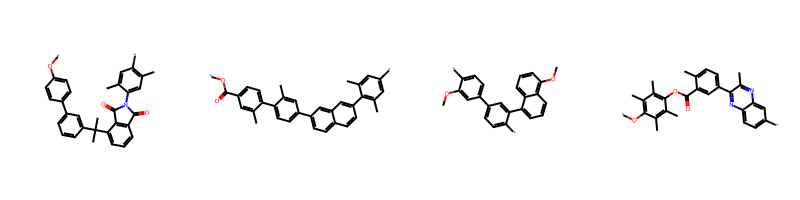

In [89]:
from datetime import time

# Подготовка данных
json_path = "data/nlp_to_gen_bridge.json"
num_samples = 5
original_df = pd.read_csv("data/polyOne_aa.csv")

# Генерация на основе похожих примеров
valid_smiles, valid_mols, target_tensor = generate_from_similar_examples(
    model=model,
    json_path=json_path,
    original_df=original_df,  # ваш исходный ненормализованный датафрейм
    scaler=scaler,            # ваш обученный scaler
    num_features=NUM_FEATURES,
    num_samples=num_samples,
    device=DEVICE
)

In [59]:
torch.save(model.state_dict(), "transformer_smiles_conditional.pth")